## Preparing a code to visualize the source generating wave in a classical field. 
This can be taken as analog to a source creating particle in a quantum field(but that particle is made up of modes 1 to N). So the coding practice is just to visualize wavepacket generation while acting as a sanity check for myself xD.

In [89]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter
import shutil


In [90]:
# 1 + 1D animation for KG field(would be classical in analog)
L = int(50) 
Nx = 2000
dx = 2*L/(Nx-1)
m = 1

In [91]:
x = np.linspace(-L,L,Nx)
cfl = 0.6
dt = cfl * dx
Tmax = 80
Nt = int(Tmax/dt)
J0 = 1.5
t0 = 15.0 
tau = 3.0
R = 2.5 
omega = 2.5

In [92]:
# defining source function
def source(t , x):
    return J0 * np.exp(-((t - t0) ** 2) / (tau**2)) * np.exp(-(x**2) / (R**2))

In [93]:
#initializing arrays, creating the FDM arrays for operators
#for Laplacian the function is

def laplacian_1d(phi):
    out = np.zeros_like(phi)
    out[1:-1] = (phi[2:] + phi[:-2] - 2*phi[1:-1])
    return out

#defining arrays for phi,phi_prev and phi_next
phi = np.zeros(Nx)
phi_prev = np.zeros(Nx)
phi_next = np.zeros(Nx)

#Partial_u (phi(x))  = pi(x)
# in 1D, delta phi is d/dx(phi(x)), ~ dphidx 
def energy_density(phi, phi_prev):
    pi = (phi - phi_prev) / dt
    dphidx = np.zeros_like(phi)
    dphidx[1:-1] = (phi[2:] - phi[:-2]) / (2 * dx)
    return 0.5 * (pi**2 + dphidx**2 + (m**2) * phi**2)

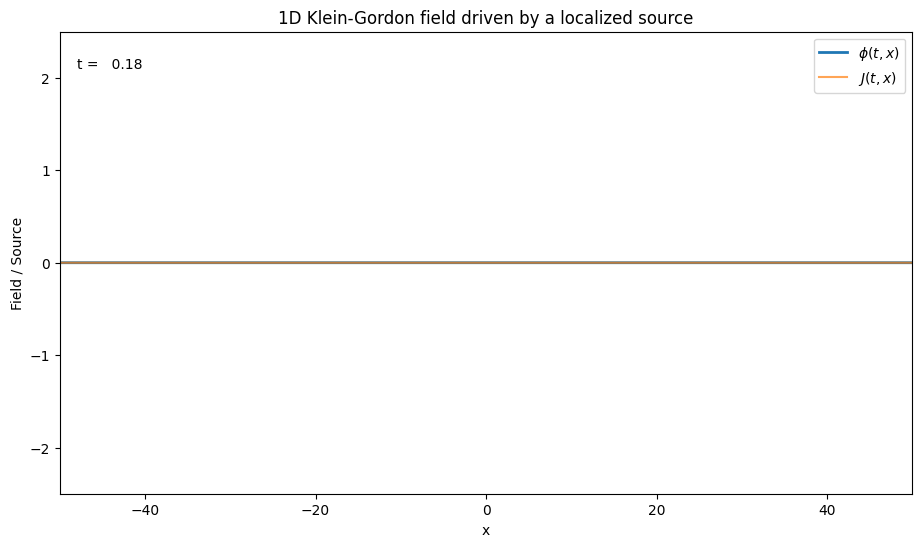

ffmpeg not detected. Saving GIF (slower, larger file)...
Saved: kg_1d_2_J0=10,w=5.gif


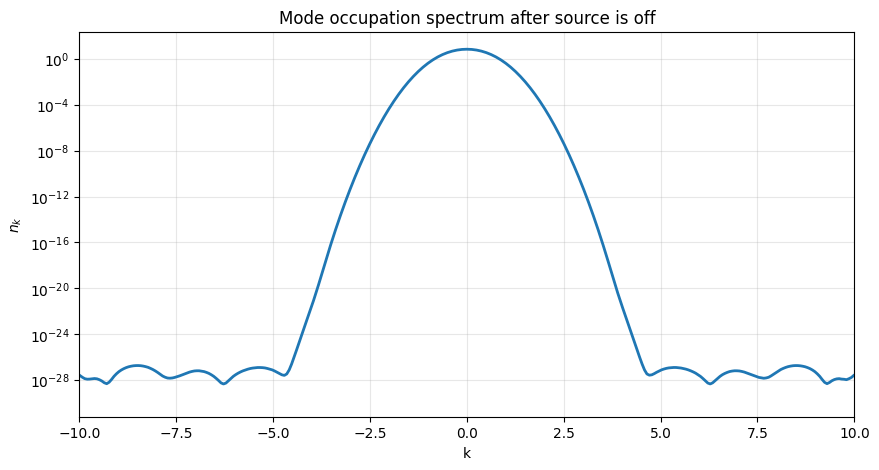

In [94]:
spectrum_times = []
spectrum_data = []

sponge_width = 10.0
gamma0 = 0.25
gamma = sponge_gamma(x)

def sponge_gamma(x):
    d = np.abs(x)
    g = np.zeros_like(x)
    mask = d > (L - sponge_width)
    s = (d[mask] - (L - sponge_width)) / sponge_width
    g[mask] = gamma0 * (s**2)
    return g

def compute_nk(phi, phi_prev):
    # pi = dphi/dt
    pi = (phi - phi_prev) / dt

    # FFT conventions
    # x spacing dx, domain length = 2L
    phi_k = np.fft.fft(phi)
    pi_k = np.fft.fft(pi)

    k = 2 * np.pi * np.fft.fftfreq(Nx, d=dx)
    omega_k = np.sqrt(k**2 + m**2)

    # Classical occupation-like number density per mode
    # n_k = (|pi_k|^2 + ω^2 |phi_k|^2) / (2 ω)
    # Normalize FFT: numpy fft is unnormalized, so multiply by dx
    phi_k = phi_k * dx
    pi_k = pi_k * dx

    nk = (np.abs(pi_k)**2 + (omega_k**2) * np.abs(phi_k)**2) / (2 * omega_k)

    return k, nk

In [ ]:
frameskip = 3
nframes = 900
interval_ms = 20

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(111)

line_phi, = ax.plot(x, phi, lw=2, label=r'$\phi(t,x)$')
line_J, = ax.plot(x, 0*x, lw=1.5, alpha=0.7, label=r'$J(t,x)$')

ax.set_xlim(-L, L)
ax.set_ylim(-2.5, 2.5)
ax.set_xlabel("x")
ax.set_ylabel("Field / Source")
ax.set_title("1D Klein-Gordon field driven by a localized source")
ax.legend(loc="upper right")

time_text = ax.text(0.02, 0.92, "", transform=ax.transAxes)
t = 0.0
def step():
    global phi_prev, phi, phi_next, t

    J = source(t, x)

    phi_xx = laplacian_1d(phi)
    accel = phi_xx - (m**2) * phi + J

    phi_next[:] = 2 * phi - phi_prev + (dt**2) * accel

    phi_next[:] = phi_next - gamma * dt * (phi - phi_prev)

    phi_next[0] = 0.0
    phi_next[-1] = 0.0

    phi_prev, phi, phi_next = phi, phi_next, phi_prev
    t += dt

def update(frame):
    for _ in range(frameskip):
        step()

    line_phi.set_ydata(phi)
    line_J.set_ydata(source(t, x) / (J0 + 1e-12))  # I scaled this for visibility

    time_text.set_text(f"t = {t:6.2f}")

    # After source is off this part governs that behavior
    if t > (t0 + 4 * tau) and (frame % 10 == 0):
        k, nk = compute_nk(phi, phi_prev)
        spectrum_times.append(t)
        spectrum_data.append((k.copy(), nk.copy()))

    return line_phi, line_J, time_text

In [ ]:
ani = FuncAnimation(fig, update, frames=1200, interval=20, blit=True)
plt.show()

fps = int(1000 / interval_ms)

ffmpeg_path = shutil.which("ffmpeg")

if ffmpeg_path is not None:
    print("ffmpeg detected. Saving MP4...")
    writer = FFMpegWriter(fps=fps, bitrate=1800)
    ani.save("kg_1d_source.mp4", writer=writer)
    print("Saved: kg_1d_source.mp4")
else:
    print("ffmpeg not detected. Saving GIF (slower, larger file)...")
    writer = PillowWriter(fps=fps)
    ani.save("kg_1d_source.gif", writer=writer)
    print("Saved: kg_1d_2_J0=10,w=5.gif")


if len(spectrum_data) > 0:
    k, nk = spectrum_data[-1]
    idx = np.argsort(k)

    plt.figure(figsize=(10, 5))
    plt.plot(k[idx], nk[idx], lw=2)
    plt.xlim(-10, 10)
    plt.yscale("log")
    plt.xlabel("k")
    plt.ylabel(r"$n_k$")
    plt.title("Mode occupation spectrum after source is off")
    plt.grid(True, alpha=0.3)
    plt.show()